In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as tf
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [2]:
dfi = pd.read_csv('./Data/Electricity/household_power_consumption_UCIml.txt', sep=';', header=0, low_memory=False,infer_datetime_format=True,parse_dates={'datetime':[0,1]})
dfi

/tmp/ipykernel_9596/1215742683.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfi = pd.read_csv('./Data/Electricity/household_power_consumption_UCIml.txt', sep=';', header=0, low_memory=False,infer_datetime_format=True,parse_dates={'datetime':[0,1]})


/tmp/ipykernel_9596/1215742683.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dfi = pd.read_csv('./Data/Electricity/household_power_consumption_UCIml.txt', sep=';', header=0, low_memory=False,infer_datetime_format=True,parse_dates={'datetime':[0,1]})


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...
2075254,2010-11-26 20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2075255,2010-11-26 20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2075256,2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0
2075257,2010-11-26 21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0


In [3]:
# Replace '?' with missing value ('NaN') and check
dfi.replace('?', 'NaN', inplace=True)
# Convert all dtypes to float and check
dfi[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']] = dfi[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']].astype('float')
dfi

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...
2075254,2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2075255,2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2075256,2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2075257,2010-11-26 21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0


In [4]:
dfi = dfi.groupby([pd.Grouper(freq='H', key='datetime')]).sum().reset_index()
dfi

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
1,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
3,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
4,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0
...,...,...,...,...,...,...,...,...
34584,2010-11-26 17:00:00,103.554,3.684,14224.18,433.0,0.0,0.0,772.0
34585,2010-11-26 18:00:00,94.408,3.222,14251.91,397.2,0.0,0.0,0.0
34586,2010-11-26 19:00:00,99.560,3.602,14204.46,423.4,0.0,4.0,0.0
34587,2010-11-26 20:00:00,69.822,3.670,14363.76,294.8,0.0,64.0,0.0


In [5]:
"""The total energy consumption was larger than the sum of the 
three sub meters combined. Therefore, add a new feature 'sub_metering_4' 
will be added according to the following calculation: global_active_power * 1000/60 - (sub_metering_1 + sub_metering_2 + sub_metering_3)"""
dfi['sub_metering_4'] = (dfi.iloc[:, 1] * 1000 / 60) - (dfi.iloc[:, 5] + dfi.iloc[:, 6] + dfi.iloc[:, 7])

<Axes: >

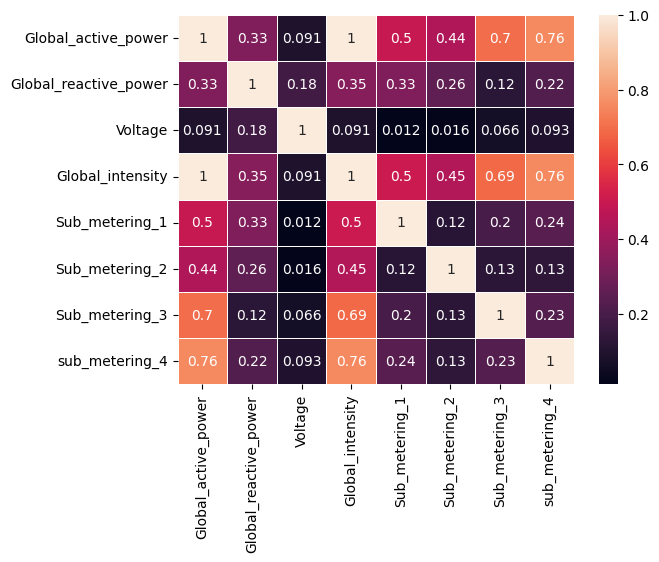

In [6]:
import seaborn as sns
corr = dfi.select_dtypes('number').corr()
sns.heatmap(data=corr, annot=True, linewidths=.5)

In [7]:
df = dfi.loc[dfi['datetime'] > '2010-06-01']
df.reset_index(inplace=True)
df.drop(['index','datetime','Global_reactive_power','Voltage','Global_intensity'],axis=1,inplace=True)
df

/tmp/ipykernel_9596/3050627526.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index','datetime','Global_reactive_power','Voltage','Global_intensity'],axis=1,inplace=True)


,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,18.802,0.0,12.0,88.0,213.366667
1,15.130,0.0,17.0,39.0,196.166667
2,18.628,0.0,29.0,88.0,193.466667
3,13.896,0.0,0.0,39.0,192.600000
4,18.002,0.0,29.0,87.0,184.033333
...,...,...,...,...,...
4288,103.554,0.0,0.0,772.0,953.900000
4289,94.408,0.0,0.0,0.0,1573.466667
4290,99.560,0.0,4.0,0.0,1655.333333
4291,69.822,0.0,64.0,0.0,1099.700000


In [8]:
df.ffill()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,18.802,0.0,12.0,88.0,213.366667
1,15.130,0.0,17.0,39.0,196.166667
2,18.628,0.0,29.0,88.0,193.466667
3,13.896,0.0,0.0,39.0,192.600000
4,18.002,0.0,29.0,87.0,184.033333
...,...,...,...,...,...
4288,103.554,0.0,0.0,772.0,953.900000
4289,94.408,0.0,0.0,0.0,1573.466667
4290,99.560,0.0,4.0,0.0,1655.333333
4291,69.822,0.0,64.0,0.0,1099.700000


In [9]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,4293.0,53.342487,43.167369,0.0,20.030000,36.782,82.356,337.610000
Sub_metering_1,4293.0,52.909154,184.318892,0.0,0.000000,0.000,0.000,2489.000000
Sub_metering_2,4293.0,56.836012,176.710909,0.0,0.000000,25.000,47.000,2405.000000
Sub_metering_3,4293.0,344.896110,406.169660,0.0,84.000000,102.000,605.000,1293.000000
sub_metering_4,4293.0,434.400171,370.948102,0.0,203.866667,293.100,511.800,2473.766667


In [10]:
df = df[['Sub_metering_1','Sub_metering_2','Sub_metering_3','sub_metering_4','Global_active_power']]
df

,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,Global_active_power
0,0.0,12.0,88.0,213.366667,18.802
1,0.0,17.0,39.0,196.166667,15.130
2,0.0,29.0,88.0,193.466667,18.628
3,0.0,0.0,39.0,192.600000,13.896
4,0.0,29.0,87.0,184.033333,18.002
...,...,...,...,...,...
4288,0.0,0.0,772.0,953.900000,103.554
4289,0.0,0.0,0.0,1573.466667,94.408
4290,0.0,4.0,0.0,1655.333333,99.560
4291,0.0,64.0,0.0,1099.700000,69.822


In [11]:
df['nxt_target'] = df['Global_active_power'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]
df

/tmp/ipykernel_9596/3025554430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nxt_target'] = df['Global_active_power'].shift(-1)
/tmp/ipykernel_9596/3025554430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]


,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,Global_active_power,nxt_target
0,0.0,12.0,88.0,213.366667,18.802,15.130
1,0.0,17.0,39.0,196.166667,15.130,18.628
2,0.0,29.0,88.0,193.466667,18.628,13.896
3,0.0,0.0,39.0,192.600000,13.896,18.002
4,0.0,29.0,87.0,184.033333,18.002,36.862
...,...,...,...,...,...,...
4288,0.0,0.0,772.0,953.900000,103.554,94.408
4289,0.0,0.0,0.0,1573.466667,94.408,99.560
4290,0.0,4.0,0.0,1655.333333,99.560,69.822
4291,0.0,64.0,0.0,1099.700000,69.822,2.804


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sub_metering_1       4293 non-null   float64
 1   Sub_metering_2       4293 non-null   float64
 2   Sub_metering_3       4293 non-null   float64
 3   sub_metering_4       4293 non-null   float64
 4   Global_active_power  4293 non-null   float64
 5   nxt_target           4293 non-null   float64
dtypes: float64(6)
memory usage: 201.4 KB


In [13]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,Global_active_power,nxt_target
0,0.0,12.0,88.0,213.366667,18.802,15.130
1,0.0,17.0,39.0,196.166667,15.130,18.628
2,0.0,29.0,88.0,193.466667,18.628,13.896
3,0.0,0.0,39.0,192.600000,13.896,18.002
4,0.0,29.0,87.0,184.033333,18.002,36.862
...,...,...,...,...,...,...
3429,0.0,68.0,867.0,1057.866667,119.572,45.878
3430,0.0,68.0,40.0,656.633333,45.878,31.462
3431,0.0,10.0,40.0,474.366667,31.462,37.936
3432,0.0,0.0,156.0,476.266667,37.936,31.086


In [14]:
train.iloc[:,-1:]

,nxt_target
0,15.130
1,18.628
2,13.896
3,18.002
4,36.862
...,...
3429,45.878
3430,31.462
3431,37.936
3432,31.086


In [15]:
train.iloc[:,:5]

,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,Global_active_power
0,0.0,12.0,88.0,213.366667,18.802
1,0.0,17.0,39.0,196.166667,15.130
2,0.0,29.0,88.0,193.466667,18.628
3,0.0,0.0,39.0,192.600000,13.896
4,0.0,29.0,87.0,184.033333,18.002
...,...,...,...,...,...
3429,0.0,68.0,867.0,1057.866667,119.572
3430,0.0,68.0,40.0,656.633333,45.878
3431,0.0,10.0,40.0,474.366667,31.462
3432,0.0,0.0,156.0,476.266667,37.936


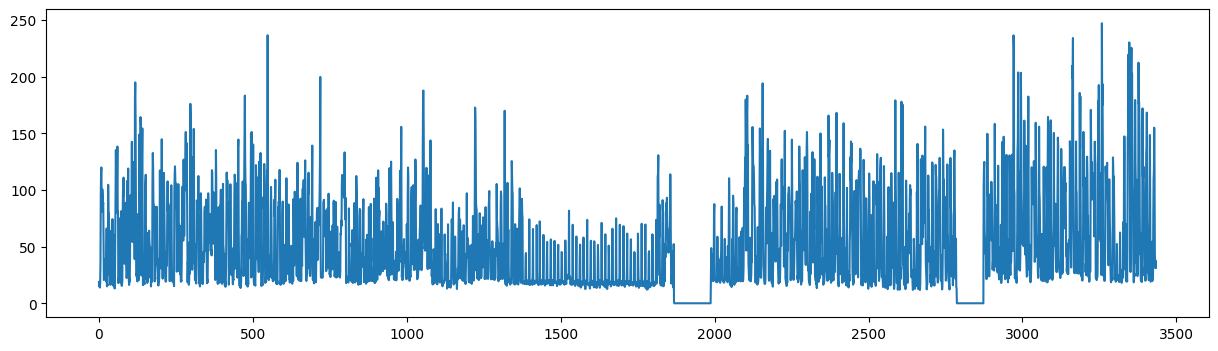

In [16]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["Global_active_power"])
plt.show()

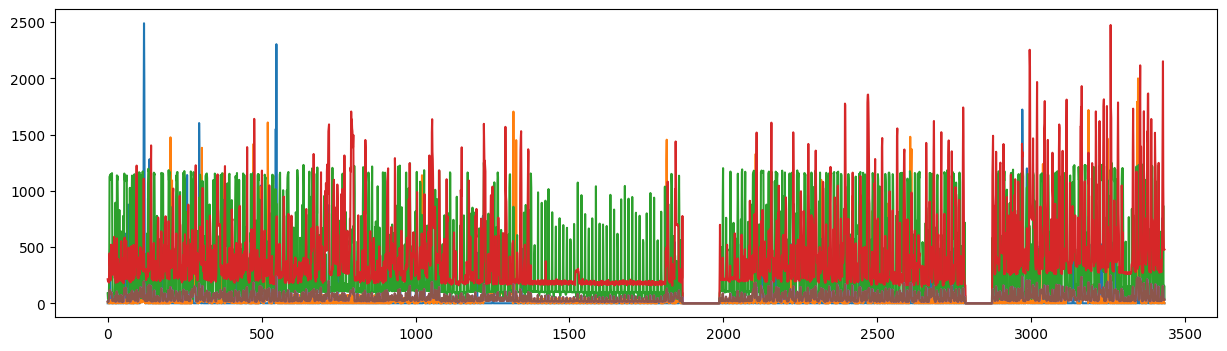

In [17]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [18]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:5])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [19]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 5
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 5
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [20]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [21]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [22]:
print(X_train.shape)
X_train[0][0]

torch.Size([3424, 10, 5])


tensor([-0.2825, -0.2641, -0.6182, -0.5173, -0.7502])

In [23]:
class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        #print('av',len(x.size()))
        if self.batch_first is True and len(x.size()) == 3:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            #h_t = h_t[0]
            #c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            #x_t = x[:, t, :]
            
            #x_t = x[:, t]
            # Concatenate input and hidden 
            x_t = x
            #print('x',x.size())
            #print('t',t)
            #print('xt',x_t.size())
            #print('ht',h_t.size())
            v_t = torch.cat((x_t, h_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [24]:
device = "cpu"

In [25]:
class AttnEncoder(nn.Module):
    def __init__(self,input_size: int, hidden_size: int, batch_first: bool = True, n_qubits:int=4, n_qlayers:int=1,seq_len:int=10):
        super(AttnEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        self.seq_len = seq_len
        self.lstm = QLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )
        self.attn = nn.Linear(
            in_features=2 * self.hidden_size + self.seq_len,
            out_features=1
        )
        self.softmax = nn.Softmax(dim=1)


    def forward(self, input_data: torch.Tensor):
        
        if self.batch_first is True and len(input_data.size())==3:
            batch_size, seq_length, features_size = input_data.size()
        else:
            batch_size, features_size = input_data.size()

        h_t = Variable(torch.zeros(batch_size, self.hidden_size))  # hidden state (output)
        c_t = Variable(torch.zeros(batch_size, self.hidden_size))  # cell state

        attentions, input_encoded = (Variable(torch.zeros(input_data.size(0), self.seq_len, self.input_size)),
                                     Variable(torch.zeros(input_data.size(0), self.seq_len, self.hidden_size)))


        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           input_data.permute(0, 2, 1).to(device)), dim=2).to(
                device)  # bs * input_size * (2 * hidden_dim + seq_len)

            e_t = self.attn(x.view(-1, self.hidden_size * 2 + self.seq_len))  # (bs * input_size) * 1
            a_t = self.softmax(e_t.view(-1, self.input_size)).to(device)  # (bs, input_size)

            weighted_input = torch.mul(a_t, input_data[:, t, :].to(device))  # (bs * input_size)
            #self.lstm.flatten_parameters()
            #print('x,et,at',x.size(), e_t.size(), a_t.size())
            #print('atinputdaata',input_data[:,t,:].size())
            #print('winput',weighted_input.size())
            
            _, (h_t, c_t) = self.lstm(weighted_input, (h_t, c_t))

            input_encoded[:, t, :] = h_t
            attentions[:, t, :] = a_t

        return attentions, input_encoded

In [26]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size: int, batch_first: bool = True, n_qubits:int=4, n_qlayers:int=1,seq_len:int=10):
        super(AttnDecoder, self).__init__()
        self.batch_first = batch_first
        self.seq_len = seq_len
        self.lstm = QLSTM(
            input_size=1,
            hidden_size=hidden_size,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )
        self.encoder_hidden_size = hidden_size
        self.decoder_hidden_size = hidden_size
        self.out_feats = 1

        self.attn = nn.Sequential(
            nn.Linear(2 * self.decoder_hidden_size + self.encoder_hidden_size, self.encoder_hidden_size),
            nn.Tanh(),
            nn.Linear(self.encoder_hidden_size, 1)
        )
        
        self.fc = nn.Linear(self.encoder_hidden_size + self.out_feats, self.out_feats)
        self.fc_out = nn.Linear(self.decoder_hidden_size + self.encoder_hidden_size, self.out_feats)
        self.fc.weight.data.normal_()

    def forward(self, input_encoded: torch.Tensor, y_history: torch.Tensor):
        if self.batch_first is True and len(input_encoded.size())==3:
            batch_size, seq_length, features_size = input_encoded.size()
        else:
            batch_size, features_size = input_encoded.size()
        
        h_t = Variable(torch.zeros(batch_size, self.decoder_hidden_size))  # hidden state (output)
        c_t = Variable(torch.zeros(batch_size, self.decoder_hidden_size))  # cell state
        
        context = Variable(torch.zeros(input_encoded.size(0), self.encoder_hidden_size))

        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           input_encoded.to(device)), dim=2)

            x = tf.softmax(
                self.attn(
                    x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size)
                ).view(-1, self.seq_len),
                dim=1)

            context = torch.bmm(x.unsqueeze(1), input_encoded.to(device))[:, 0, :]  # (batch_size, encoder_hidden_size)
           # print('con_yhis',context.size(),y_history.size())
            y_tilde = self.fc(torch.cat((context.to(device), y_history.to(device)),
                                        dim=1))  # (batch_size, out_size)

            #self.lstm.flatten_parameters()
           # print('ytilde', y_tilde.size())
            _, (h_t, c_t) = self.lstm(y_tilde, (h_t, c_t))
        #print('ht_con', h_t.size(),context.size())
        return self.fc_out(torch.cat((h_t, context.to(device)), dim=1))  # predicting value at t=self.seq_length+1


In [27]:
class AutoEncForecast(nn.Module):
    def __init__(self,input_size: int, hidden_size: int, batch_first: bool = True, n_qubits:int=4, n_qlayers:int=1,seq_len:int=10):
        super(AutoEncForecast, self).__init__()
        self.encoder = AttnEncoder(input_size, hidden_size, batch_first, n_qubits, n_qlayers,seq_len).to(device)
        self.decoder = AttnDecoder(hidden_size, batch_first, n_qubits, n_qlayers,seq_len).to(device)

    def forward(self, encoder_input: torch.Tensor, y_hist: torch.Tensor, return_attention: bool = False):
       
        attentions, encoder_output = self.encoder(encoder_input)
        outputs = self.decoder(encoder_output, y_hist.float())
        outputs = torch.transpose(outputs, 0, 1)
        if return_attention:
            return outputs, attentions
        return outputs

In [28]:
batch_size = 5
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = AutoEncForecast(input_size=5, hidden_size= 12, n_qubits=5)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 5)
weight_shapes = (n_qlayers, n_qubits) = (1, 5)


In [29]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)
count = 0


for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        output = modelQ(x,y)
        
        label = torch.transpose(y, 0, 1)    
        #print(output)
        #print(torch.transpose(y, 0, 1))
        
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:71.01095936234103 
[2/5]  LossQ:3.9376786925149645 
[3/5]  LossQ:2.4864927548151172 
[4/5]  LossQ:1.8422917472166773 
[5/5]  LossQ:1.5349970303811915 


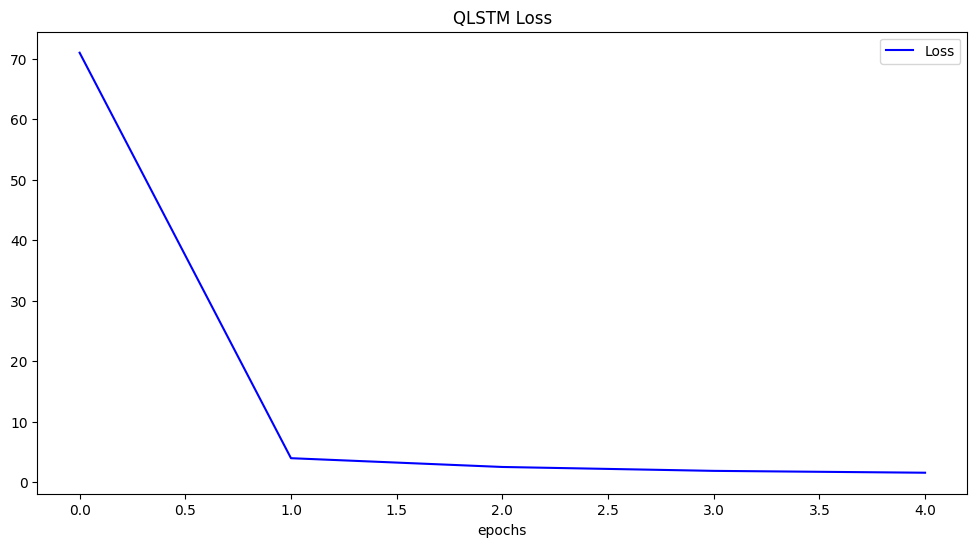

In [30]:
np.savetxt('./SavedModels/Electricity/household_power_consump/loss/qlstm_attn.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [31]:
print(len(X_test))
print(len(X_train))
print(len(y_train))
#print(X_train[0].unsqueeze(0))
#print(y_train[0].unsqueeze(0))

849
3424
3424


In [32]:
def predict(X,y, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for i in range(len(X)):
            y_star = model(X[i].unsqueeze(0),y[i].unsqueeze(0))
            '''if list(y_star.size()) == [1,1]:
                y_star = y_star.tolist()
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star = torch.tensor(y_star)'''
            output = torch.cat((output, y_star), 0)


    return output

In [33]:
pred_y_test = predict(X_test,y_test, modelQ)
print(len(pred_y_test))
print(pred_y_test)

849
tensor([[ 3.7584e-01],
        [-5.1100e-01],
        [ 8.5320e-03],
        [-8.5326e-01],
        [-5.7910e-01],
        [ 3.1227e-01],
        [ 2.6167e-01],
        [ 1.3756e+00],
        [-1.3287e-01],
        [-1.0382e+00],
        [ 3.1257e-01],
        [-9.8067e-01],
        [-8.4662e-01],
        [-9.5603e-01],
        [-9.6638e-01],
        [-1.0192e+00],
        [-6.7222e-01],
        [ 1.4593e+00],
        [ 4.9335e-01],
        [ 1.6096e-01],
        [-9.1519e-01],
        [-1.0108e-01],
        [ 1.1142e+00],
        [ 7.6124e-01],
        [ 1.7654e+00],
        [ 1.6157e+00],
        [ 1.6836e+00],
        [ 2.5943e+00],
        [ 1.6544e+00],
        [ 7.6902e-01],
        [ 5.9466e-01],
        [ 2.6399e+00],
        [ 1.4611e-01],
        [ 1.1395e+00],
        [ 6.5823e-01],
        [ 3.8497e-01],
        [ 9.7204e-01],
        [ 6.4430e-01],
        [-4.1589e-01],
        [-9.7058e-01],
        [-9.8140e-01],
        [-9.6112e-01],
        [-6.7425e-01],
       

In [34]:
pred_y_train = predict(X_train,y_train, modelQ)
print(len(pred_y_train))
print(pred_y_train)

3424
tensor([[ 1.2987],
        [ 1.1879],
        [ 0.9530],
        ...,
        [-0.2880],
        [-0.4626],
        [-0.4614]])


In [35]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [36]:
print(len(pred_y_train))
print(len(y_train))

3424
3424


In [37]:
pred_y_test

tensor([[ 3.7584e-01],
        [-5.1100e-01],
        [ 8.5320e-03],
        [-8.5326e-01],
        [-5.7910e-01],
        [ 3.1227e-01],
        [ 2.6167e-01],
        [ 1.3756e+00],
        [-1.3287e-01],
        [-1.0382e+00],
        [ 3.1257e-01],
        [-9.8067e-01],
        [-8.4662e-01],
        [-9.5603e-01],
        [-9.6638e-01],
        [-1.0192e+00],
        [-6.7222e-01],
        [ 1.4593e+00],
        [ 4.9335e-01],
        [ 1.6096e-01],
        [-9.1519e-01],
        [-1.0108e-01],
        [ 1.1142e+00],
        [ 7.6124e-01],
        [ 1.7654e+00],
        [ 1.6157e+00],
        [ 1.6836e+00],
        [ 2.5943e+00],
        [ 1.6544e+00],
        [ 7.6902e-01],
        [ 5.9466e-01],
        [ 2.6399e+00],
        [ 1.4611e-01],
        [ 1.1395e+00],
        [ 6.5823e-01],
        [ 3.8497e-01],
        [ 9.7204e-01],
        [ 6.4430e-01],
        [-4.1589e-01],
        [-9.7058e-01],
        [-9.8140e-01],
        [-9.6112e-01],
        [-6.7425e-01],
        [-9

In [38]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [39]:
np.savetxt('./SavedModels/Electricity/household_power_consump/train/qlstm_attn.txt',y_train_pred)
np.savetxt('./SavedModels/Electricity/household_power_consump/test/qlstm_attn.txt',y_test_pred)

Training dataset RMSE:1.0149280867292263


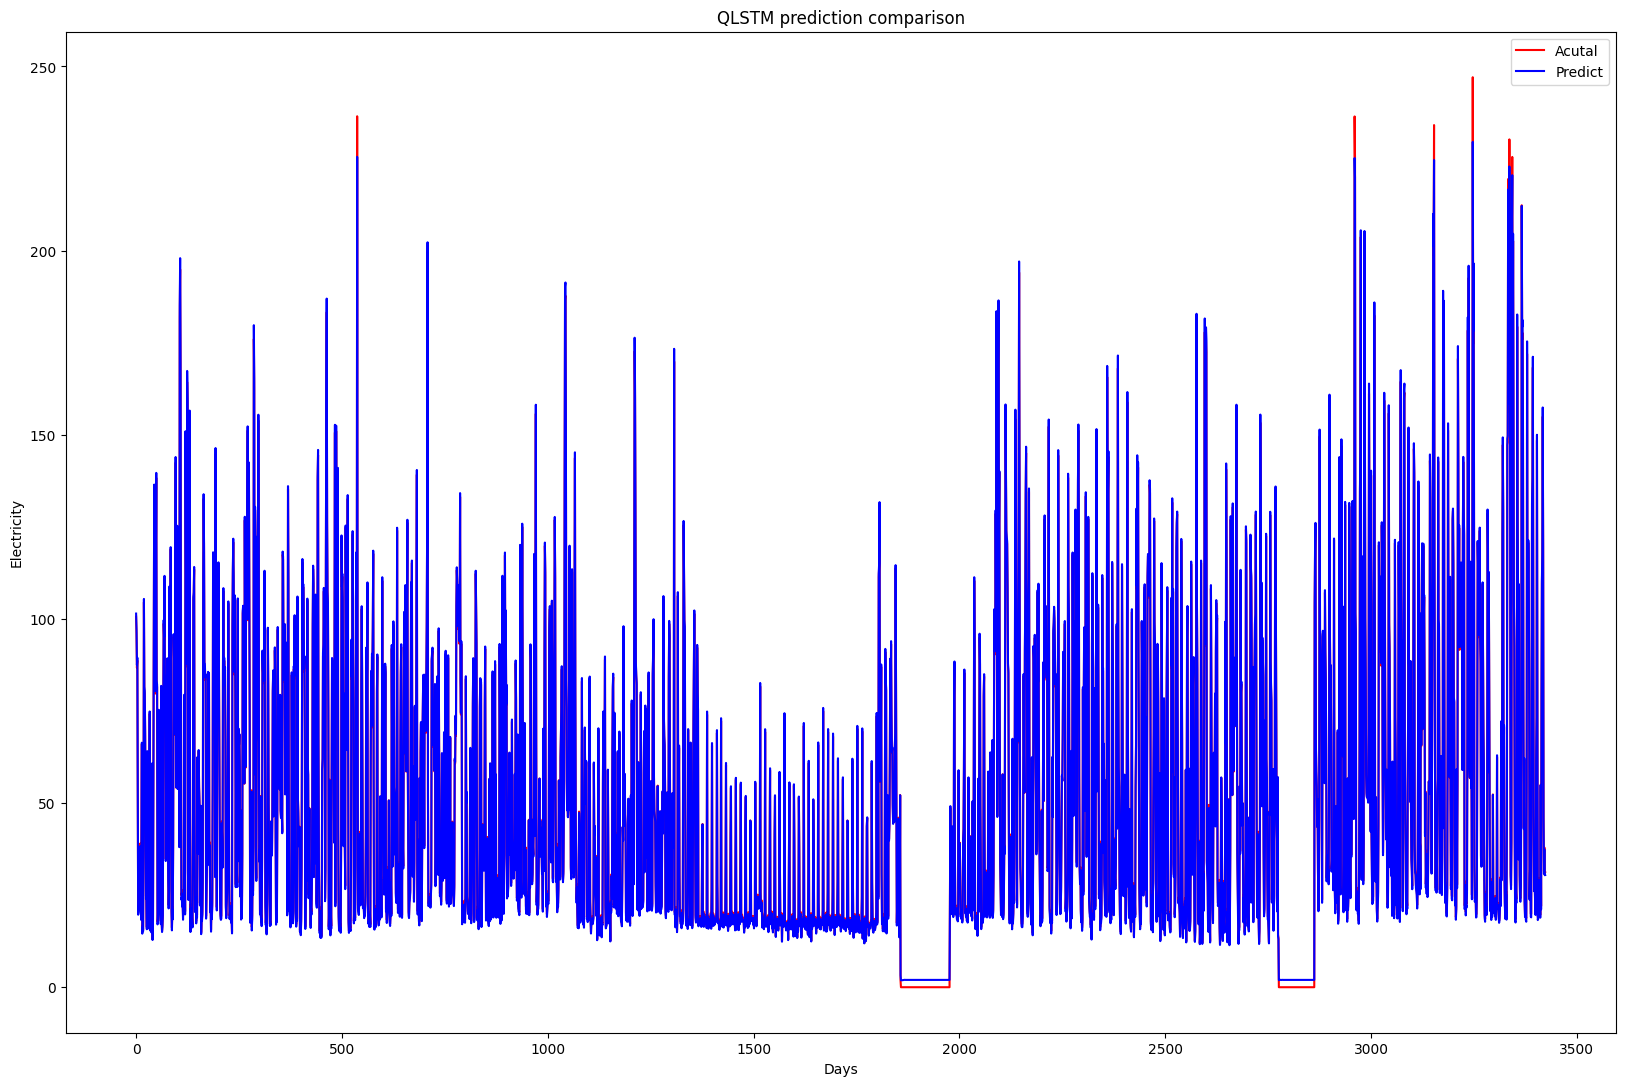

In [40]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:10.671703264899296


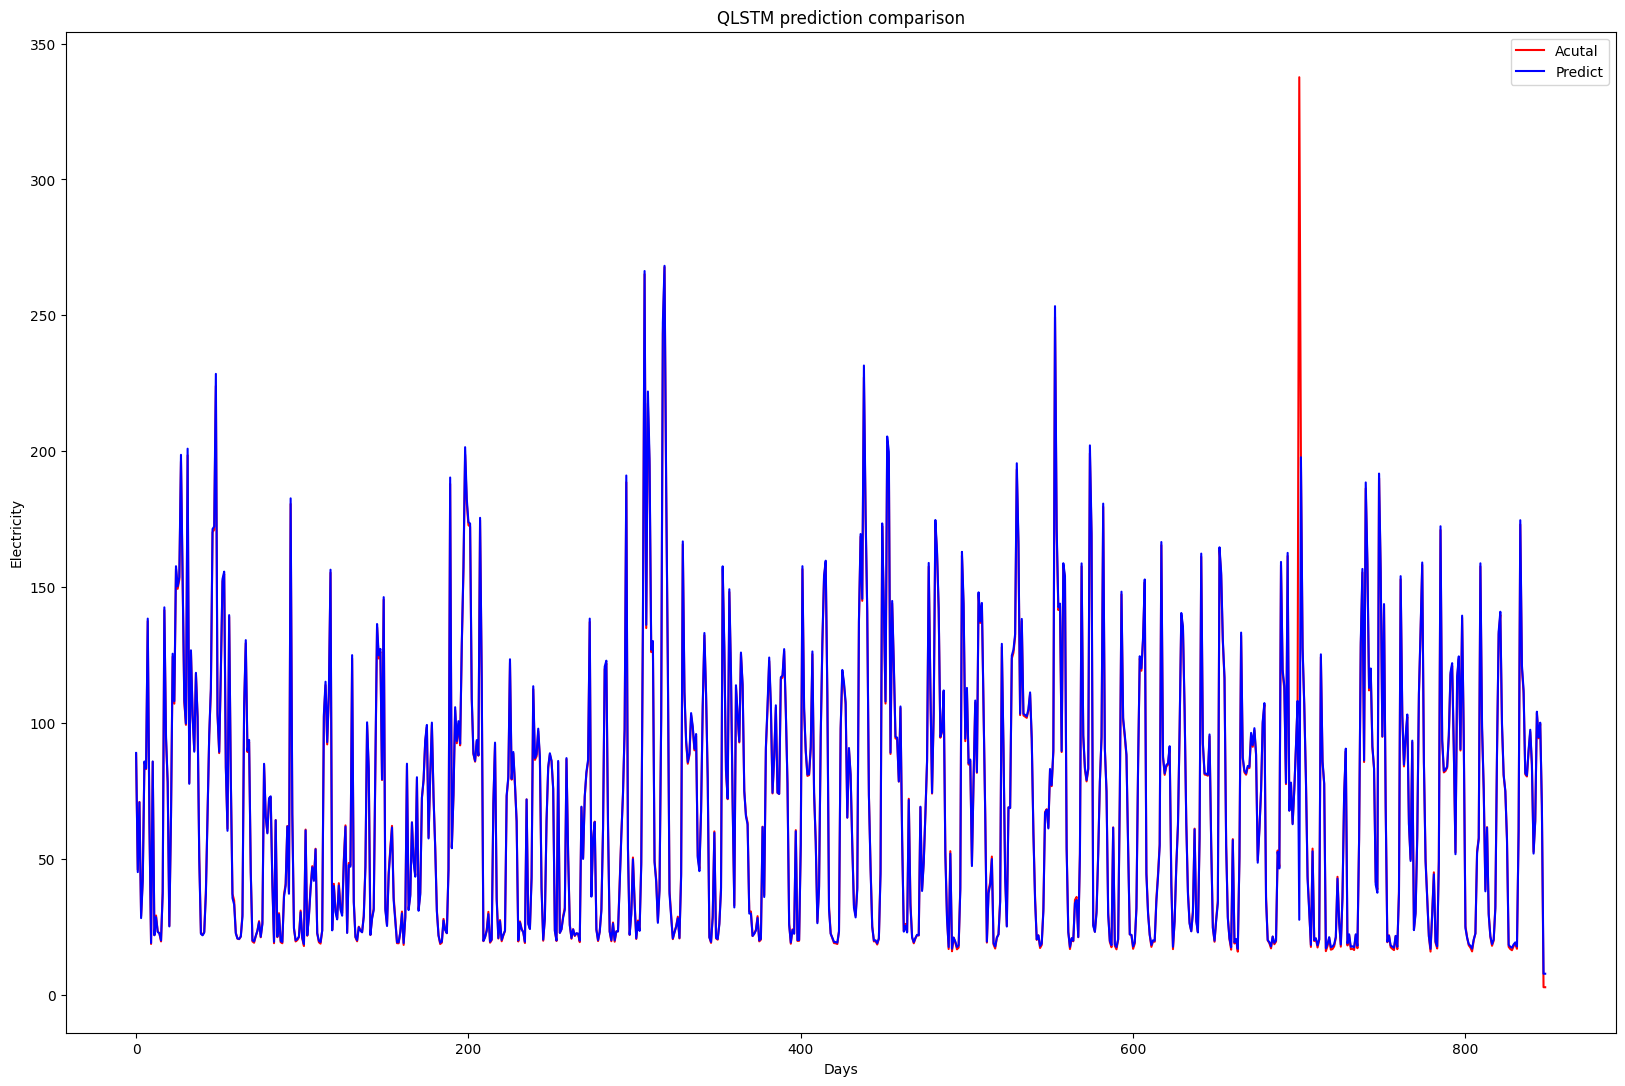

In [41]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [42]:
torch.save(modelQ.state_dict(),'./SavedModels/Electricity/household_power_consump/model/QLSTM_attn_sd')